# How to quickly create arbitrary profiles
This is a short guide on using aribtrary profiles in the adiabatic-tides framework.

This is a rather advanced topic, and it is recommended that you have read the paper and looked at the other notebooks first. In particular it requires that you perform some tests to check that your numerical profile is well converged in phase space. Here I will show an example, how to do this.

For this we use the new class NumericalProfile. A NumericalProfile just requires a set of radii and densities as an input and it will then interpolate and integrate these to get any other properties of the profile (like the mass profile, potential, phase space distributions etc.)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os

import numpy as np
sys.path.append("../..")
import adiabatic_tides as at
from scipy.optimize import curve_fit

#h5cache = "../../caches/halo_grid.hdf5"

In [2]:
nfw = at.profiles.NFWProfile(10., m200c=1e8)

r = np.logspace(-10,5, 2000)

myprof = at.profiles.NumericalProfile(r, nfw.density(r))
myprof2 = at.profiles.NumericalProfile(r, nfw.density(r)*(nfw.rs/(r+nfw.rs)))

# Examples of outputs, and consistency checks

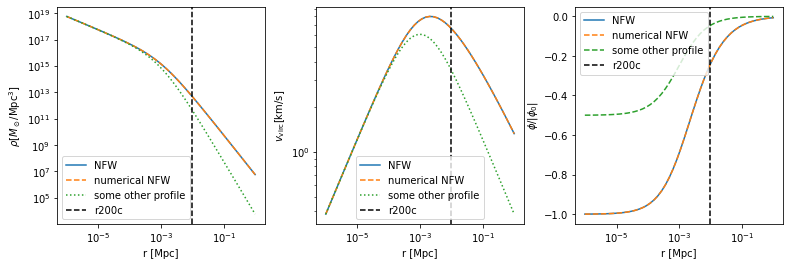

In [3]:
# Here some examples of what you can do with a profile
# Note that the default units are masses in Msol, lengths in Mpc and velocities in km/s
r = np.logspace(-3, 3) * nfw.rs

fig, axs = plt.subplots(1,3, figsize=(13,4))
fig.subplots_adjust(wspace=0.25)
axs[0].loglog(r, nfw.density(r), label="NFW")
axs[0].loglog(r, myprof.density(r), label="numerical NFW", linestyle="dashed")
axs[0].loglog(r, myprof2.density(r), label="some other profile", linestyle="dotted")
axs[0].set_ylabel(r"$\rho [M_\odot / $Mpc$^3]$")

axs[1].loglog(r, nfw.vcirc(r), label="NFW")
axs[1].loglog(r, myprof.vcirc(r), label="numerical NFW", linestyle="dashed")
axs[1].loglog(r, myprof2.vcirc(r), label="some other profile", linestyle="dotted")
axs[1].set_ylabel(r"$v_{\rm{virc}} [$km/s$]$")

axs[2].semilogx(r, nfw.potential(r) / np.abs(nfw.phi0), label="NFW")
axs[2].semilogx(r, myprof.potential(r) / np.abs(nfw.phi0), label="numerical NFW", linestyle="dashed")
axs[2].semilogx(r, myprof2.potential(r) / np.abs(nfw.phi0), label="some other profile", linestyle="dashed")
axs[2].set_ylabel(r"$\phi / |\phi_0|$")


for ax in axs:
    ax.set_xlabel(r"r [Mpc]")
    ax.axvline(nfw.r200c, label="r200c", color="black", linestyle="dashed")
    ax.legend()

# Phase space distributions, etc.

This part comes without warranty

The Numerical profile also allows you to do the Eddington inversion, create phase space distributions, sample particles and to create adiabatic-tides models. However, I cannot promise you that this will work reliably under all circumstances, since there are a lot of numerical parameters that are involved in this. Different profiles may require different choices for convergence.
If you want to use any of these phase space aspects, you probably should create a subclass of NumericalProfile and put a function _initialize_numerical_scales(), which will initialize default values for the numerical scales. You can then experiment with the scales until you find something that is reasonably accurate. You can search for different exampels of this function in profiles.py to get an idea.
The main benchmark that I recommend here, is to test that integrating the phase space profile gives back the correct initial density profile (within 1 percent or so). 

I will give you an example below of something that I have used myself in practice.

## Subclassing NumericalProfile

Here I create a profile with the form

$$
A r^{-3/2} \exp(-\alpha (r/r_B)^\beta 
$$

This profile is an analytic approximation to the remnant of a prompt cusp that went through a stellar encounter. If you are interested in the physics, you can check out the paper [arXiv:2301.04670](https://arxiv.org/abs/2301.04670). However, the physical motivation is not really important there.

In [4]:
class ShockedCuspProfile(at.profiles.NumericalProfile):
    """This is the profile of a prompt cusp -- powerlaw plus the truncation from a stellar encounter"""
    def __init__(self, A, rB=1., alpha=1.256, beta=0.639):
        self.base_powerlaw = at.profiles.PowerlawProfile(rhoc=A, rscale=1., slope=-1.5)
        
        # Define the density profile
        ri = np.logspace(-20,20, 10000) * rB
        rhoi = A*ri**-1.5 * np.exp(- alpha * (ri/rB)**beta)
        
        # Call the constructor of the parent class 'NumericalProfile'
        # Note that here we use ancorphi="min", making the potential zero at r=0 (and not at r->infty).
        # This normalization can be useful for profiles that originate from powerlaws
        super().__init__(ri=ri, rhoi=rhoi, r0=rB, ancorphi="rmin")
        
    def _initialize_numerical_scales(self):
        """Sets some default values for numerical scales"""
        
        super()._initialize_numerical_scales()
        
        # By experimenting (see below) I have found that
        
        # A) I should use more integration steps than the default choice and 
        #    create larger phase space interpolation tables
        self._sc["fintegration_nstepsE"] = 501 # (default: 201)
        self._sc["fintegration_nstepsL"] = 201 # (default: 101)
        self._sc["ip_e_of_jl_nbinsE"] = 2000 # (default: 1000)
        self._sc["ip_e_of_jl_nbinsL"] = 200 # (default: 100)

        # And should consider lower minimum energies
        self._sc["log_emin"] = -18                # (default -10)
        
    def density_transfer_function(self, r, alpha=1.243, beta=0.637):
        return np.exp(- alpha * (r/self.rB)**beta)

## Consistency experiment

We check that integrating the phase space distribution of our profile correctly reproduces the initial profile. This is a consistency check that checks a lot of things. This might go wrong at the following points:
* The Eddington Inversion to get f_of_e of the initial profile
* Setting up accurate enough interpolation tables to parametrize the initial f_of_jl
* The integration of f(J,L) to obtain the density profile

Therefore, if this works, you can be quite sure that your profile will behave well under all circumstances. If you have problems getting this to agree, you might want to check some of the intermediate steps. For this, you might want to consider some of the verification methods in the verification directory.

To do this check we create an AdiabaticProfile with vanbishingly small tidal field and iterate it a few times. If this works it is very likely that  adiabatic iterations with tidal field will also work well.

In [5]:
%%time
sprof = ShockedCuspProfile(A=1.)
zero_tide_prof_i1 = at.profiles.AdiabaticProfile(prof_initial=sprof, tide=1e-20, verbose=1, niter=1, nbins=150)
zero_tide_prof_i5 = at.profiles.AdiabaticProfile(prof_initial=sprof, tide=1e-20, verbose=1, niter=5, nbins=150)

i=1, mfrac=1.00063, dt=43.9s
i=1, mfrac=1.00063, dt=23.8s
i=2, mfrac=1.00093, dt=23.6s
i=3, mfrac=1.00107, dt=23.7s
i=4, mfrac=1.00113, dt=23.8s
i=5, mfrac=1.00116, dt=24.0s
CPU times: user 2min 25s, sys: 17 s, total: 2min 42s
Wall time: 2min 42s


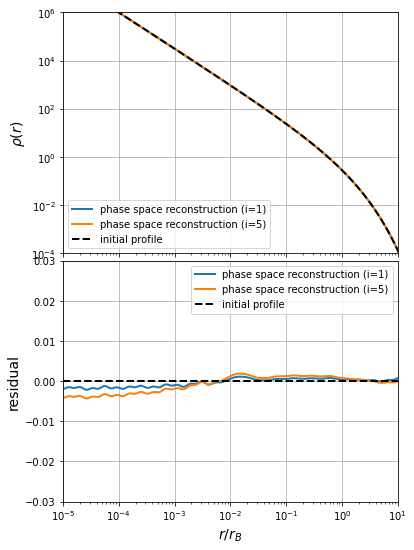

In [6]:
fig, axs = plt.subplots(2,1, figsize=(6,9), sharex=True)
fig.subplots_adjust(hspace=0.03)

ri = np.logspace(-8,3, 400)

axs[0].loglog(ri, zero_tide_prof_i1.self_density(ri), lw=2, label="phase space reconstruction (i=1)")
axs[0].loglog(ri, zero_tide_prof_i5.self_density(ri), lw=2, label="phase space reconstruction (i=5)")
axs[0].loglog(ri, sprof.density(ri), lw=2, color="black", linestyle="dashed", label="initial profile")

axs[1].semilogx(ri, zero_tide_prof_i1.self_density(ri) / sprof.density(ri) - 1., lw=2, label="phase space reconstruction (i=1)")
axs[1].semilogx(ri, zero_tide_prof_i5.self_density(ri) / sprof.density(ri) - 1., lw=2, label="phase space reconstruction (i=5)")
axs[1].axhline(0., lw=2, color="black", linestyle="dashed", label="initial profile")

axs[0].set_ylim(1e-4,1e6)
axs[1].set_ylim(-0.03,0.03)

axs[0].set_ylabel(r"$\rho(r)$", fontsize=14)
axs[1].set_ylabel(r"residual", fontsize=14)
axs[1].set_xlabel(r"$r/r_{B}$", fontsize=14)
    
for ax in axs:
    ax.grid("on")
    ax.set_xlim(1e-5,1e1)
    ax.legend()

# Using the class

Now, that all phase space aspects of our profile should be well behaved, we can use it for anything, that we could do with an analytic profile. Probably most intriguing are the following cases:

* We can create a particle realization of our profile (with isotropic phase space). This could be directly used for initial conditions of N-body simulations

`pos,vel, mass = sprof.sample_particles(10000, rmax=1e2)`

* We can create Adiabatic Tides models with non-zero tidal fields, e.g.

`aprof = at.profiles.AdiabaticProfile(prof_initial=sprof, tide=1e-7, verbose=1, niter=..., nbins=150, h5cache=...)`